In [20]:
import keras
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Input, concatenate

warnings.simplefilter(action="ignore", category=FutureWarning)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



#### Pre-process the data

In [2]:
# load listing data
listing_data = pd.read_csv('./data/listings.csv')

# copy the data frame to apply changes savely
new_listing_df = listing_data.copy()

# data pre-processing
# drop identifiers & unrequired columns
drop_cols_list = [
    'scrape_id', 'name', 'description', 'neighborhood_overview',
    'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about',
    'host_response_time', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications',
    'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type',
    'bathrooms_text', 'amenities', 'license', 'last_scraped', 'source', 'host_since', 'calendar_updated',
    'calendar_last_scraped', 'first_review', 'last_review'
]
new_listing_df.drop(drop_cols_list, axis=1, inplace=True)

# drop records with null [price, host_response_rate, host_acceptance_rate] value
new_listing_df = new_listing_df.dropna(axis=0, subset=['price', 'host_response_rate', 'host_acceptance_rate'])

# encode T/F columns 
tf_columns = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
    'has_availability', 'instant_bookable',     
]
label_encoder = LabelEncoder().fit(new_listing_df['host_is_superhost'])
for col in tf_columns:
    new_listing_df[col] = label_encoder.transform(new_listing_df[col])

# fill null numerical values with median
cols_to_fill_miss_values = [
    'reviews_per_month', 'review_scores_value', 'review_scores_location', 'review_scores_communication',
    'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_rating', 'beds',
    'bedrooms', 'bathrooms', 
]
for col in cols_to_fill_miss_values:
    new_listing_df[col] = new_listing_df[col].fillna(new_listing_df[col].median())

# convert object values to numerical values
obj_cols = ['host_response_rate', 'host_acceptance_rate']
for col in obj_cols:
    new_listing_df[col] = pd.to_numeric(new_listing_df[col].map(lambda val: val.replace('%', '')))
new_listing_df['price'] = pd.to_numeric(new_listing_df['price'].map(lambda val: val.replace('$', '').replace(',', '')))


# all two columns('images_names', 'images_No') with none values
new_listing_df['images_names'] = [None for _ in range(len(new_listing_df))]
new_listing_df['images_No'] = [ 0 for _ in range(len(new_listing_df))]

new_listing_df.to_csv('./data/preprocessed_listings.csv')

In [3]:
new_listing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19142 entries, 1 to 37763
Data columns (total 47 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            19142 non-null  int64  
 1   listing_url                                   19142 non-null  object 
 2   host_response_rate                            19142 non-null  int64  
 3   host_acceptance_rate                          19142 non-null  int64  
 4   host_is_superhost                             19142 non-null  int32  
 5   host_listings_count                           19142 non-null  float64
 6   host_total_listings_count                     19142 non-null  float64
 7   host_has_profile_pic                          19142 non-null  int32  
 8   host_identity_verified                        19142 non-null  int32  
 9   latitude                                      19142 non-null 

* #### We need to fill new columns (images_names, images_No) using script_of_image_scraping file first then follow 

In [8]:
# read and prepare data
img_size = (224, 224)
data = pd.read_csv('./data/preprocessed_listings.csv')
data = data.drop('Unnamed: 0', axis=1)[data['images_No'] == 5] # drop 'Unnamed: 0' column and use only recordes with images. 

C:\Users\Hossam Aboouf\AppData\Local\Temp\ipykernel_22788\1733170965.py:3: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data/preprocessed_listings.csv')


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1268 entries, 0 to 1323
Data columns (total 47 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            1268 non-null   int64  
 1   listing_url                                   1268 non-null   object 
 2   host_response_rate                            1268 non-null   int64  
 3   host_acceptance_rate                          1268 non-null   int64  
 4   host_is_superhost                             1268 non-null   int64  
 5   host_listings_count                           1268 non-null   float64
 6   host_total_listings_count                     1268 non-null   float64
 7   host_has_profile_pic                          1268 non-null   int64  
 8   host_identity_verified                        1268 non-null   int64  
 9   latitude                                      1268 non-null   f

### Fine tune CV model

In [6]:
def get_paths_and_prices(df):
    paths = []
    prices = []
    for _, row in df.iterrows():
        for name in row['images_names'].split(','):
            paths.append(f'./images/{name}')
            prices.append(row['price'])
    return paths, prices

def customise_data(data):
    x_train, x_test, _, _ = train_test_split(data, [0 for _ in range(len(data))], test_size=.2, shuffle=True, random_state=303)
    paths, prices = get_paths_and_prices(x_train)
    dict_ = {
        'imgs': paths,
        'prices': prices
    }
    new_x_train = pd.DataFrame(dict_)

    paths, prices = get_paths_and_prices(x_test)
    dict_ = {
        'imgs': paths,
        'prices': prices
    }
    new_x_test = pd.DataFrame(dict_)

    return new_x_train, new_x_test

In [10]:
train_df, test_df = customise_data(data)

# fine tune CV model (Inception v3)
# Create the model
img_input = Input(shape=(img_size[0], img_size[1], 3))
Incep3_base_model = InceptionV3(weights="imagenet", include_top=False, input_tensor=img_input)

# stop weight update
for layer in Incep3_base_model.layers:
    layer.trainable = False

# update inseption model strcture by adding some layers to make it deal with our price prediction task
Incep3_base_model = Incep3_base_model(img_input, training=False)
Incep3_base_model = GlobalAveragePooling2D(name="avg_pool")(Incep3_base_model)
Incep3_base_model = BatchNormalization()(Incep3_base_model)
Incep3_base_model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_hidden_cv')(Incep3_base_model)
Incep3_base_model = Dense(1, activation='linear')(Incep3_base_model)
Incep3_model = Model(inputs=img_input, outputs=Incep3_base_model)

# initialize hyper-prameters
lr = 0.1 
verbose = 1
epochs = 100
batch_size = 64 
        
Incep3_model.compile(optimizer=Adam(learning_rate=lr, epsilon=1), metrics=['mse'], loss='mse')
Incep3_model.summary()
# plot_model(Incep3_model, show_shapes=True, to_file='./inceptionV3_model_image.png')
stop = EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True, mode='min', verbose=verbose)
best = ModelCheckpoint(
    filepath='./model/best_iv3_weights.keras',
    save_best_only=True,
    monitor='val_loss',
    verbose=verbose,
    mode='min'
)

train_img_generator = ImageDataGenerator(
    brightness_range=(0.75, 1),
    shear_range=0.1,
    zoom_range=[0.50, 1],
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
test_img_generator = ImageDataGenerator(rescale=1.0)

imgs_train = train_img_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col="imgs",  
        y_col="prices",  
        class_mode="raw",  
        color_mode='rgb',
        target_size=img_size,
        batch_size=batch_size
        )
imgs_test = test_img_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col="imgs",
        y_col="prices",
        class_mode="raw",
        color_mode='rgb',
        target_size=img_size,
        batch_size=batch_size
        )

hist = Incep3_model.fit(
    imgs_train, 
    validation_data = imgs_test,
    batch_size=batch_size,
    verbose=verbose,
    epochs=epochs,
    callbacks=[stop, best]
)

Incep3_model.save('./model/last_iv3_model_simple.keras')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_cv (Dense)         │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,942,177 (83.70 MB)

 Trainable params: 135,297 (528.50 KB)

 Non-trainable params: 21,806,880 (83.19 MB)

Found 5070 validated image filenames.
Found 1270 validated image filenames.


c:\Users\Hossam Aboouf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\Hossam Aboouf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100


c:\Users\Hossam Aboouf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 35786.0898 - mse: 35900.0859
Epoch 1: val_loss improved from inf to 69936.89844, saving model to ./model/best_iv3_weights.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - loss: 35777.2188 - mse: 35893.2734 - val_loss: 69936.8984 - val_mse: 70367.5938
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - loss: 36501.1719 - mse: 35608.3164
Epoch 2: val_loss did not improve from 69936.89844
80/80 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - loss: 36460.0898 - mse: 35571.5195 - val_loss: 70186.3594 - val_mse: 69948.3203
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - loss: 30606.0488 - mse: 30609.1777
Epoch 3: val_loss did not improve from 69936.89844
80/80 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - loss: 30620.6914 - mse: 30624.0234 - val_loss: 70410.9062 - val_mse: 70797.6094
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - loss: 31258.6113 - mse: 31306.0605
Epoch 4: val_loss did not improve from 69936.89844
80/80 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step 

### Fine tune model for structure data

In [11]:
# read, prepare and split data
data_std = data.drop(['id', 'listing_url', 'images_names', 'images_No'], axis=1)
y_data_std = data_std['price']
x_data_std = data_std.drop('price', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data_std, y_data_std, test_size=.2, shuffle=True, random_state=303)

In [46]:
# build std model (simple MLP algorithm)
input_layer = Input(shape=(x_train.shape[1],), name='input_layer_std')
base_model = Dense(x_train.shape[1], activation='relu', kernel_initializer='he_normal')(input_layer)
base_model = Dense(25, activation='relu', name='dense_hidden_std')(base_model)
output_layer = Dense(1, activation='linear')(base_model)
model_std = Model(inputs=input_layer, outputs=output_layer)

print(model_std.summary())

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_std (InputLayer)    │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_std (Dense)        │ (None, 25)             │         1,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,907 (11.36 KB)

 Trainable params: 2,907 (11.36 KB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
# compile and train the model
epochs = 400
lr = ExponentialDecay(0.01, decay_steps=100000, decay_rate=0.96, staircase=True)
stop = EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True, mode='min', verbose=verbose)
best = ModelCheckpoint(
    filepath='./model/best_std_weights.keras',
    save_best_only=True,
    monitor='val_loss',
    verbose=verbose,
    mode='min'
)

model_std.compile(
    loss="mean_squared_error",
    metrics=[MeanSquaredError()],
    optimizer=Adam(learning_rate=lr, epsilon=1)
)
# plot_model(model_std, show_shapes=True, to_file='./model_std.png')

hist_std = model_std.fit(
    x_train, y_train,
    epochs=epochs,
    callbacks=[stop, best],
    validation_data=([x_test, y_test])
)

model_std.save('./model/last_std_weights.keras')

Epoch 1/400
 1/32 ━━━━━━━━━━━━━━━━━━━━ 18s 592ms/step - loss: 253317.4688 - mean_squared_error: 253317.4688
Epoch 1: val_loss improved from inf to 69836.10938, saving model to ./model/best_std_weights.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 78115.6016 - mean_squared_error: 78115.6016 - val_loss: 69836.1094 - val_mean_squared_error: 69836.1094
Epoch 2/400
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 16508.6855 - mean_squared_error: 16508.6855
Epoch 2: val_loss did not improve from 69836.10938
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42303.2695 - mean_squared_error: 42303.2695 - val_loss: 70052.0391 - val_mean_squared_error: 70052.0391
Epoch 3/400
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 15703.2363 - mean_squared_error: 15703.2363
Epoch 3: val_loss did not improve from 69836.10938
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24029.2090 - mean_squared_error: 24029.2090 - val_loss: 72643.3984 - val_mean_squared_error: 72643.3984
Epoch 4/400
 1/32 ━━━━━━━━━━━━

### Fine tune multi-modal model

In [15]:
def split_XY_data(df:pd.DataFrame):
    df_copy = df.copy()
    x_imgs = []
    y = []
    for i, row in df.iterrows():
        img_names = row['images_names'].split(',')
        for img_name in img_names:
            img_path = f'./images/{img_name}'
            # print(img_path)
            img = load_img(img_path, target_size=img_size)
            img = img_to_array(img)
            # img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
            x_imgs.append(img)
            y.append(row['price'])
    Y = pd.DataFrame({'price': y})
    x_std = df_copy.drop(['id', 'listing_url', 'images_names', 'images_No', 'price'], axis=1)
    x_std = pd.DataFrame(np.repeat(x_std.values, 5, axis=0), columns=x_std.columns)
    
    return np.array(x_imgs), x_std, Y 

In [16]:
# python code to create the final architecture

train_df, test_df, _, _ = train_test_split(data, [0 for _ in range(len(data))], test_size=.2, shuffle=True, random_state=303)
# load data (training)
x_train_imgs, x_train_std, y_train = split_XY_data(train_df)
print(f'X_train imgs len: {len(x_train_imgs)}')
print(f'X_train std shape: {x_train_std.shape}')
print(f'Y_train std shape: {y_train.shape}')

# load data (testing)
x_test_imgs, x_test_std, y_test = split_XY_data(test_df)
print(f'X_test imgs len: {len(x_test_imgs)}')
print(f'X_test std shape: {x_test_std.shape}')
print(f'Y_test std shape: {y_test.shape}')

X_train imgs len: 5070
X_train std shape: (5070, 42)
Y_train std shape: (5070, 1)
X_test imgs len: 1270
X_test std shape: (1270, 42)
Y_test std shape: (1270, 1)


In [17]:
# build multimodal NN

# load fine tuned models
# 1) load computer vision model
cv_tuned_model_path = './model/best_iv3_weights.keras'
cv_tuned_model = keras.models.load_model(cv_tuned_model_path, compile=False)
# 2) load structured model
std_tuned_model_path = './model/best_std_weights.keras'
std_tuned_model = keras.models.load_model(std_tuned_model_path, compile=False)

# remove last layer from each model
# just to simply identify the layers after concatenation we will add postfix (_cv, _std) for layers
# _cv => to layers of computer vision model layers
# _std => to layers of structure NN model layers
cv_tuned_model_layer = Model(inputs=cv_tuned_model.input, outputs=cv_tuned_model.layers[-2].output)
for layer in cv_tuned_model_layer.layers:
    layer._name = f'{layer.name}_cv'
std_tuned_model_layer = Model(inputs=std_tuned_model.input, outputs=std_tuned_model.layers[-2].output)
for layer in std_tuned_model_layer.layers:
    layer._name = f'{layer.name}_std'

In [18]:
# concate models and add 2 final layer
multimodal_structure = concatenate([
    cv_tuned_model_layer.output,
    std_tuned_model_layer.output
])
multimodal_structure = Dense(50, activation='relu', name='dense_hidden_final')(multimodal_structure)
multimodal_structure = Dense(1, activation='linear')(multimodal_structure)

# build model
multimodal_model = keras.Model(inputs=[
    cv_tuned_model_layer.input[0], 
    std_tuned_model_layer.input[0]],
    outputs=[multimodal_structure]
)

# model compilation
lr = 0.01
multimodal_model.compile(
    optimizer=Adam(learning_rate=lr, epsilon=1),
    loss="mean_squared_error",
    metrics=[ MeanSquaredError()]
)

print(multimodal_model.summary())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 5, 5,      │ 21,802,784 │ input_layer[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_pool            │ (None, 2048)      │          0 │ inception_v3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_std     │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ avg_pool[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 42)        │      1,806 │ input_layer_std[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_hidden_cv     │ (None, 64)        │    131,136 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_hidden_std    │ (None, 25)        │      1,075 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 89)        │          0 │ dense_hidden_cv[… │
│ (Concatenate)       │                   │            │ dense_hidden_std… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_hidden_final  │ (None, 50)        │      4,500 │ concatenate_2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         51 │ dense_hidden_fin… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,949,544 (83.73 MB)

 Trainable params: 21,911,016 (83.58 MB)

 Non-trainable params: 38,528 (150.50 KB)

None


In [101]:
# plot model
plot_model(
    multimodal_model,
    dpi=350,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    to_file="multimodal_model.png"
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [19]:
# fit model
stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, mode='min', verbose=verbose)
best = ModelCheckpoint(
    verbose=1,
    mode='min',
    monitor='val_loss',
    save_best_only=True, 
    save_weights_only=False, 
    filepath='./model/best_multimodal_weights.keras'
)

hist_multimodal = multimodal_model.fit(
    [x_train_imgs, x_train_std],
    y_train,                   
    epochs=epochs,
    batch_size = 256,
    validation_data=([x_test_imgs, x_test_std], y_test),
    callbacks=[stop, best]
)

Epoch 1/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 23948.4707 - mean_squared_error: 23948.4707
Epoch 1: val_loss improved from inf to 53250.72656, saving model to ./model/best_multimodal_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 250s 10s/step - loss: 23797.1230 - mean_squared_error: 23797.1230 - val_loss: 53250.7266 - val_mean_squared_error: 53250.7266
Epoch 2/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 18638.5801 - mean_squared_error: 18638.5801
Epoch 2: val_loss improved from 53250.72656 to 51812.46094, saving model to ./model/best_multimodal_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 223s 10s/step - loss: 18539.0664 - mean_squared_error: 18539.0664 - val_loss: 51812.4609 - val_mean_squared_error: 51812.4609
Epoch 3/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 16242.9043 - mean_squared_error: 16242.9043
Epoch 3: val_loss improved from 51812.46094 to 51208.70703, saving model to ./model/best_multimodal_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 228s 10s/step - loss: 16216

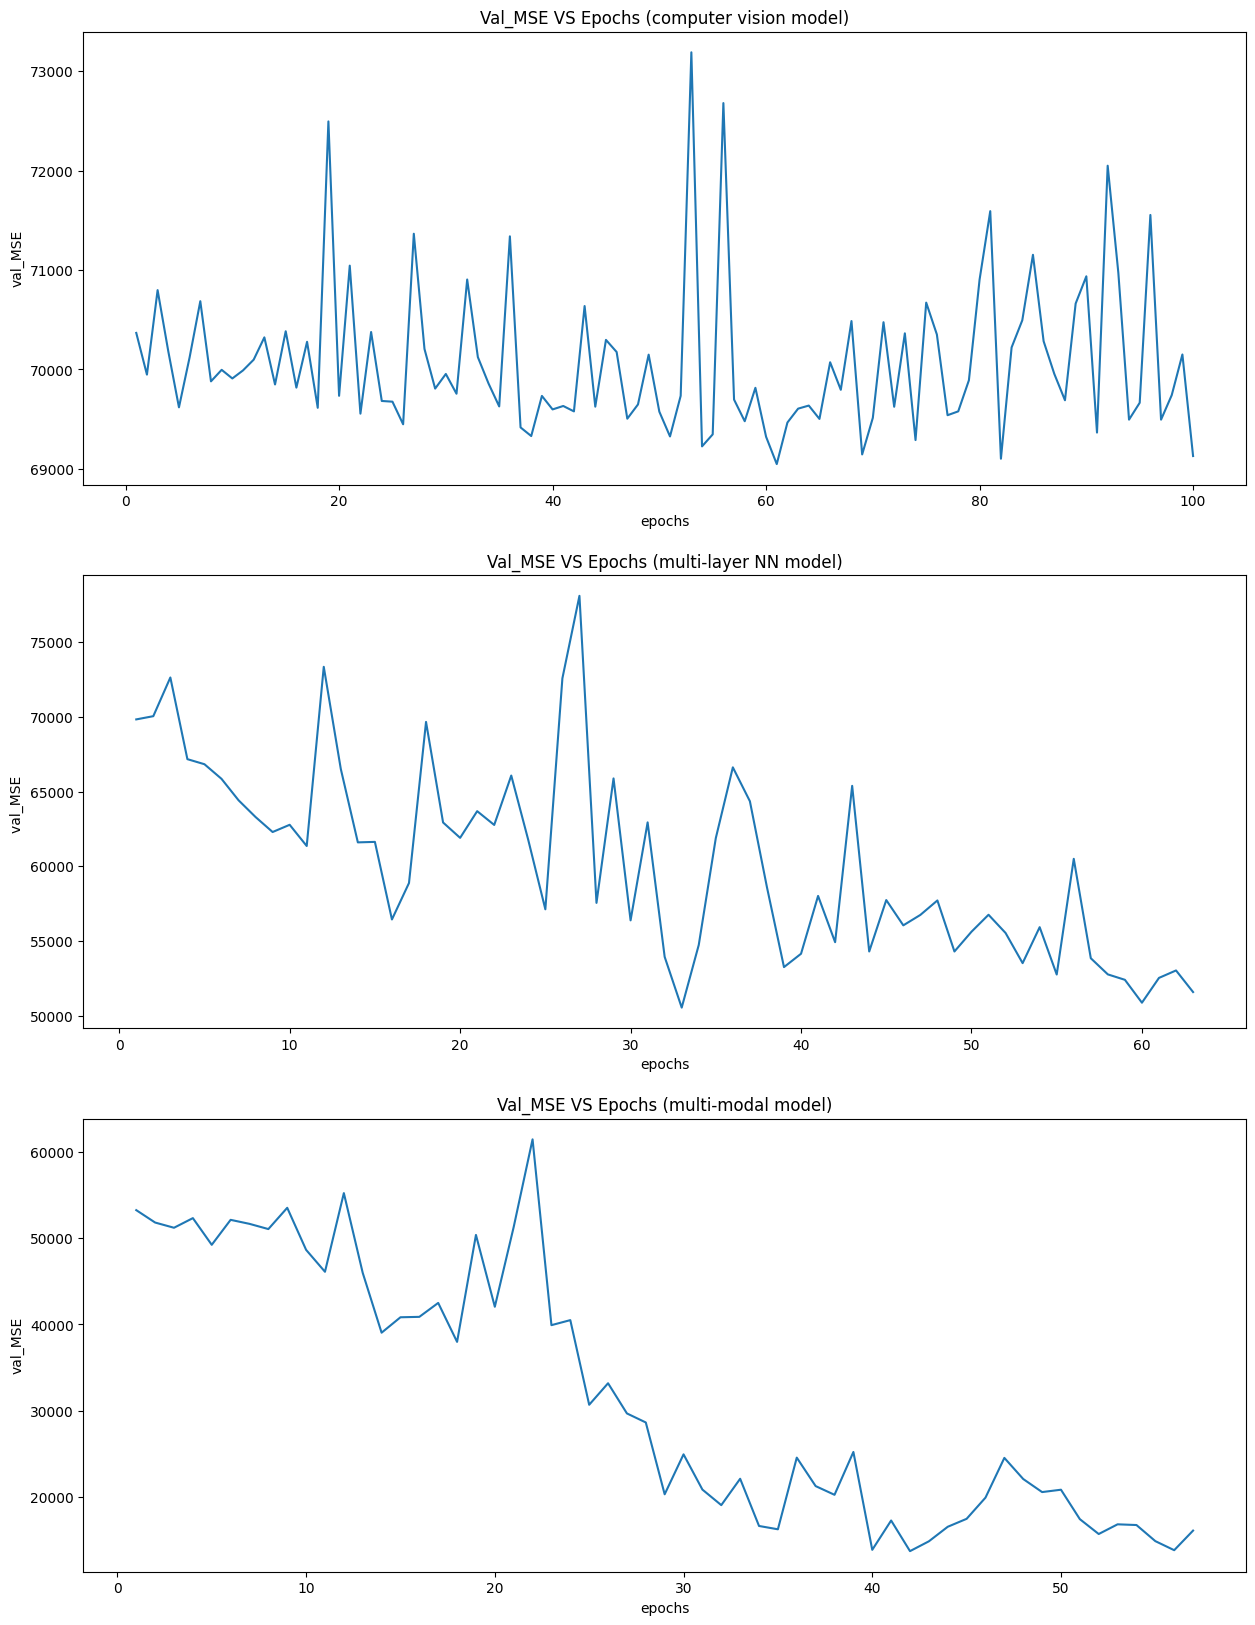

In [70]:
%matplotlib inline
val_mse_cv = hist.history['val_mse']
val_mse_std = hist_std.history['val_mean_squared_error']
val_mse_multi = hist_multimodal.history['val_mean_squared_error']

plt.figure(figsize=(15, 20))
plt.subplot(311)
plt.plot(list(range(1, len(val_mse_cv)+1)), val_mse_cv, linestyle='-')
plt.ylabel('val_MSE')
plt.xlabel('epochs')
plt.title('Val_MSE VS Epochs (computer vision model)')

plt.subplot(312)
plt.plot(list(range(1, len(val_mse_std)+1)), val_mse_std, linestyle='-')
plt.ylabel('val_MSE ')
plt.xlabel('epochs')
plt.title('Val_MSE VS Epochs (multi-layer NN model)')

plt.subplot(313)
plt.plot(list(range(1, len(val_mse_multi)+1)), val_mse_multi, linestyle='-')
plt.ylabel('val_MSE')
plt.xlabel('epochs')
plt.title('Val_MSE VS Epochs (multi-modal model)')

plt.show()